# **App Simulation**

## Machine Learning Step
## Felipe Daiha Alves

# **Objetivo**

Relatório da etapa de *Machine Learning* contendo informações do processo de construção do modelo de **Inatividade de Simulações** por parte dos clientes em aplicativos bancários. A finalidade é predizer a **probabilidade do cliente simular no próximo dia útil**.

O conjunto de dados foi construído a parte em fase de processamento de dados e levado à um *S3 Bucket* para consumo posterior.

# **Environment**

Inicialmente, iremos realizar o processo de **preparo do ambiente de trabalho** para que o conjunto de dados esteja pronto para elaboração de modelos.

### **Importando Pacotes Necessários**

In [1]:
import logging
import sys
import os
import re
from random import choice
from datetime import datetime
from warnings import filterwarnings
import dotenv
from decouple import config
import boto3
import awswrangler as wr
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import log_loss, roc_curve, auc
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.model_selection import cross_validate
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
import shap

### **Funções do Projeto**

##### 1 - logger_config

In [2]:
def logger_config():
    """
    Configurate logger format for monitoring steps in ML pipeline.
    """
    # Var logger
    logger = logging.getLogger("Logger")
    logger.setLevel(logging.DEBUG)
    # Criando formatter
    formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
    # Console handler para maior level no log e Adicionando formatter ao handler
    handler = logging.StreamHandler()
    handler.setLevel(logging.DEBUG)
    handler.setFormatter(formatter)
    # Adicionando handlers a feature 'logger'
    logger.addHandler(handler)
    # Retorno da funcao
    return logger

##### 2 - get_object_s3

In [3]:
def get_object_s3(bucket: str, prefix: str):
    """
    Get object from S3 Bucket, based on
    bucket name and date reference for prefix.
    """
    # Armazenando objetos do bucket em uma lista
    list_objects = wr.s3.list_objects(f"s3://{bucket}/")
    try:
        # Filtrando dados na lista de objetos e mostrando chave do objeto puxado
        regex_file = re.compile(f".*{prefix}")
        objects = list(filter(regex_file.match, list_objects))
        if len(objects) == 1:
            # Pegando path no bucket
            key_object = objects[0]
            # Pegando nome do arquivo
            obj_file = re.search(f"(?<={prefix}).*", key_object)
            obj_file = obj_file.group()
            # Log de aviso da chave trazida
            log.warning("S3 File <> %s", obj_file)
            # Lendo arquivo .csv buscado
            dataframe_object = wr.s3.read_csv(key_object)
            # Log de sucesso na execucao
            log.info("File '%s' from AWS S3 Bucket succesfully loaded!", obj_file)
        else:
            # Log de aviso de retorno vazio
            log.error(
                "There is no key object from prefix '%s' in this S3 bucket.",
                prefix
            )
    except ImportError:
        # Log de erro na execucao
        log.error(
            "Something went wrong... Could not read '%s' file from this S3 Bucket!",
            obj_file
        )
    # Retorno da funcao
    return dataframe_object

##### 3 - binary_requested

In [4]:
def binary_requested(dataset: pd.DataFrame):
    """
    Transform feature to bool,
    based on operator condition
    """
    # Criando uma copia do db original
    df_transformed = dataset
    # Puxando valores de 'loan_amount' do quantil 25% onde
    # cliente simulou no dia seguinte
    filtered_dataframe = df_transformed.loc[df_transformed['will_simulate_d1'] == 1]
    requested_limit = filtered_dataframe["rolling_avg_loan_amount"].quantile(.25)
    # Criando coluna com flag
    df_transformed["flag_over_loan_quantile"] = np.where(
        df_transformed["rolling_avg_loan_amount"] >= requested_limit,
        1, 0)
    # Retornando resultado
    return df_transformed

##### 4 - ntile_transformation

In [5]:
def ntile_transformation(dataset: pd.DataFrame, columns: list, cuts: int):
    """
    Convert float columns to ordinal numbers,
    based on quantile number of cuts.
    """
    # Declarando copia do db para variaveis ordinais e lista de variaveis transformadas
    ntile_df = dataset
    ordinal_columns = columns
    # Casos <= 0 (valores nulos previamente transformados), retornar para NaN
    ntile_df[ordinal_columns] = ntile_df[
        ordinal_columns].mask(ntile_df[ordinal_columns] <= 0, np.nan)
    # Selecionar apenas colunas desejadas
    ntile_df = ntile_df.loc[:, ordinal_columns]
    # Aplicando cortes as colunas por regra de quantil
    ntile_df = ntile_df.apply(lambda x: pd.qcut(x, q=cuts, labels=range(1, cuts+1)))
    # Casos NA, tratar com o maior corte (logica seguida no EDA)
    ntile_df[ordinal_columns] = ntile_df[ordinal_columns].fillna(cuts)
    # Adicionando prefixo as variaveis
    ntile_df = ntile_df.add_prefix('ntile_').astype('int64')
    # Join entre dataframes criados
    final_df = dataset.join(ntile_df)
    # Retorno do resultado
    return final_df

##### 5 - bind_ordinal_year_mon

In [6]:
def bind_ordinal_year_mon(data: pd.DataFrame):
    """
    Create date feature formatted as 'YYYY-MM'
    for ordinal split folds based on index.
    """
    # Copia do dataset
    dataset_with_truncated = data
    # Puxar mes de referencia da data
    dataset_with_truncated["date_truncated"] = dataset_with_truncated['date'].dt.to_period('M')
    # Criando dataframe com meses unicos
    unique_months = pd.DataFrame(
        dataset_with_truncated.date_truncated.dropna().unique(), columns=['date_truncated'])
    unique_months["ordinal_year_month"] = range(1, len(unique_months) + 1)
    # Join dos meses unicos com o dataframe de ML
    dataset_with_truncated = dataset_with_truncated.merge(unique_months, on='date_truncated', how='left')
    # Ordenando dataframe pela feature 'date'
    dataset_with_truncated = dataset_with_truncated.sort_values(
        'date', ascending=True).reset_index(drop=True)
    # Dropando coluna temporaria
    dataset_with_truncated = dataset_with_truncated.drop("date_truncated", axis=1)
    # Retorno da funcao
    return dataset_with_truncated

##### 6 - create_custom_folds

In [7]:
def create_custom_folds(data: pd.DataFrame, feature: str, lagged_months: int):
    """
    Create custom folds for cross validation step.
    The CV folds has to respect the time effect over the features.
    """
    # Checando se tipo da variavel corresponde a integer
    feature_type = (data[feature].dtype.kind in 'i')
    if feature_type == True:
        # Extraindo intervalo dos folds
        max_ordinal_month = int(max(data[feature]))
        min_interval = max_ordinal_month - lagged_months
        # Se min_interval < 1, considerar min_interval = 1
        min_interval = max(min_interval, 1)
        # Construindo estrutura do custom_folds para validacao cruzada de treino e teste
        list_train_fold = [
            np.array(
                data.index[
                    data[feature] <= n
                ].tolist()
            ) for n in range(min_interval, max_ordinal_month, 1)
        ]
        list_test_fold = [
            np.array(
                data.index[
                    data[feature] == n
                ].tolist()
            ) for n in range(min_interval + 1, max_ordinal_month + 1, 1)
        ]
        # Train e Test folds na mesma lista
        folds = list(zip(list_train_fold, list_test_fold))
        # Log de sucesso na execucao
        log.info("Custom folds from series '%s' in dataframe succesfully built!", feature)
    else:
        log.error("Feature '%s' is not from integer type!\nCould not create custom folds.", feature)
    # Retorno da funcao
    return folds

##### 7 - target_weights

In [8]:
def target_weights(data: pd.DataFrame, target: str):
    """
    Create new feature, based on target proportion.
    Will be used to deal with imbalanced classes on Cross Validation phase.
    """
    # Definindo peso as classes, baseado em 1 - porcentagem de ocorrencia
    weights = data.groupby([target])[target].count()/len(data)
    weights = weights.reset_index(name="weights")
    weights["weights"] = (1 - weights["weights"])
    # Atribuindo valores dos peso ao dataframe original
    df_with_weights = data.merge(weights, on=target, how="left")
    # Retorno do resultado
    return df_with_weights

##### 8 - estimators_predictions

In [9]:
def estimators_predictions(cross_val: dict, df_features: pd.DataFrame, y_from_data: pd.DataFrame, len_basis: int):
    """
    Append predictions values from each
    estimator created in cross validation step in a list.
    """
    # Lista vazia para futuro armazenamento
    preds_list = []
    # Loop entre estimadores e dados
    for i in range(0, len_basis):
        # Chamando estimador
        estimator_fold_n = cross_val["estimator"][i]
        # Previsao de valores dos index de teste de cada fold
        y_pred_fold_n = estimator_fold_n.predict_proba(
            df_features[(
                df_features.ordinal_year_month == i + 2
            )].drop("ordinal_year_month", axis=1)
        )
        # Probabilidade de ser 1
        y_pred_fold_n = y_pred_fold_n[:, 1]
        # Puxando valor real do conjunto testado
        y_true = y_from_data.filter(
            items=np.array(
                y_from_data.index[
                    y_from_data["ordinal_year_month"] == i + 2
                ]
            ).tolist(), axis=0
        )["will_simulate_d1"]
        # Bind de valores
        y_results = pd.DataFrame({
            'predictions': y_pred_fold_n,
            'true': y_true
        })
        # Append de valores a lista vazia
        preds_list.append(y_results)
    # Retorno da lista
    return preds_list

##### 9 - dumb_log_loss

In [10]:
def dumb_log_loss(class_ratio: list, multi=100):
    """
    Input a list of ratios of your classes and
    outputs a random guessing log-loss.
    """
    if sum(class_ratio)!=1.0:
        log.warning("Sum of ratios should be 1 for best results")
        class_ratio[-1]+=1-sum(class_ratio)
    actuals=[]
    for i,val in enumerate(class_ratio):
        actuals=actuals+[i for x in range(int(val*multi))]
    preds=[]
    for i in range(multi):
        preds+=[class_ratio]
    return log_loss(actuals, preds)

##### 10 - metrics_from_cv

In [11]:
def metrics_from_cv(cross_val: dict, metrics: list, title: str):
    """
    Print metrics result from cross validation process.
    """
    # Print na tela do dataset analisado
    print(f"'{title}' set metrics results:\n")
    # Para cada metrica...
    for i in metrics:
        # Puxar valor medio e desvio padrao
        result = cross_val[f"test_{i}"].mean()
        std = cross_val[f"test_{i}"].std() * 2
        # Print na tela dos resultados
        print(f"{i}: {result:0.3f} (+/-{std:0.3f})")

##### 11 - test_dumb_comparative

In [12]:
def test_dumb_comparative(cross_val: dict):
    """
    Check if log loss from test set is lower than the dumb log loss value.
    """
    # Declarando valores de logloss em comparacao ao 'dumb_log_loss'
    test_logloss = -cross_val["test_neg_log_loss"].mean()
    dumb_logloss = dumb_log_loss([.5,.5])
    # Comparando com logloss de teste do modelo
    if dumb_logloss > test_logloss:
        print(f"\n(OKAY <> Logloss average {test_logloss:0.3f} from model \
is lower than {dumb_logloss:0.3f} from random guessing.)")
    else:
        print(f"\n(WARNING <> Logloss average {test_logloss:0.3f} from model \
is greater than {dumb_logloss:0.3f} from random guessing.)")

##### 12 - plot_metrics_by_fold

In [13]:
def plot_metrics_by_fold(folds_list: list, metrics: list, cross_val_1: dict, cross_val_2: dict):
    """
    Plot metrics result from cross validation process by each fold.
    """
    # Criando layout dos plots como output
    fig, axes = plt.subplots(1, 2, figsize=(18, 5))
    # Para cada metrica...
    for i in metrics:
        # Criar evolucao nas folds para cross_val_1
        sns.lineplot(
            ax=axes[metrics.index(i)],
            x=folds_list,
            y=cross_val_1[f"test_{i}"],
            color='red'
        ).set(title="Metric in Test - {i}")
        # Criar evolucao nas folds para cross_val_2
        sns.lineplot(
            ax=axes[metrics.index(i)],
            x=folds_list,
            y=cross_val_2[f"test_{i}"],
            color='black'
        ).set(title=f"Metric in Test - {i}")
        # Plotando legenda das imagens
        axes[metrics.index(i)].legend(["Uncalibrated", "Calibrated"], loc='lower right')

##### 13 - plot_auc_roc

In [14]:
def plot_auc_roc(pred_list: list, title: str):
    """
    Creating AUC/ROC Curve plot for each fold prediction.
    """
    # Loop para puxar cada dataframe inserido na lista
    for i in enumerate(len(pred_list)):
        predictions = pred_list[i]["predictions"]
        true = pred_list[i]["true"]
        # Metricas de avaliacao no modelo
        fpr, tpr, threshold = roc_curve(true, predictions)
        roc_auc = auc(fpr, tpr)
        # Plot do grafico da curva ROC
        plt.title(f'AUC/ROC Curve - {title} Model')
        color = "#"+''.join([choice('0123456789ABCDEF') for j in range(6)])
        plt.plot(fpr, tpr, 'b', label = f'Fold {i + 1} = {roc_auc:0.3f}', c=color)
        plt.legend(loc = 'lower right')
        plt.plot([0, 1], [0, 1], color='lightgrey', linestyle='dashed')
        plt.xlim([0, 1])
        plt.ylim([0, 1])
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
    # Retorno da funcao
    return plt.show()

##### 14 - plot_calibrated_curve

In [15]:
def plot_calibrated_curve(pred_list: list, title: str):
    """
    Plot probability calibration curve for a specific prediction set.
    """
    # Loop para puxar cada dataframe inserido na lista
    for i in enumerate(len(pred_list)):
        predictions = pred_list[i]["predictions"]
        true = pred_list[i]["true"]
        # Declarando variavel das curvas de calibracao
        fop, mpv = calibration_curve(
            true, predictions, n_bins=10)
        # Plotando curva 'perfeita'
        plt.plot([0, 1], [0, 1], color='lightgrey', linestyle='dashed')
        # Plot dos dados de teste
        color = "#"+''.join([choice('0123456789ABCDEF') for j in range(6)])
        plt.plot(mpv, fop, marker='.', label = f'Fold {i + 1}', c=color)
        plt.legend(loc = 'lower right')
        plt.title(f'Calibrated Curve - {title} Model')
        plt.ylabel('Fraction of Positives (Positive Class: 1)')
        plt.xlabel('Mean Predicted Probability (Positive Class: 1)')
    # Retorno da funcao
    return plt.show()

##### 15 - explainer_for_fold

In [16]:
def explainer_for_fold(
    cross_val: dict, fold_number: int, df_features: pd.DataFrame, sample: int
):
    """
    Generate explainer for shap values
    in a specific fold in cross validation result.
    """
    # Chamando estimador
    estimator_fold_number = cross_val["estimator"][fold_number]
    # Conjunto de teste e escolhendo numero maximo de registros
    x_test_in_fold = df_features[(
            df_features.ordinal_year_month == fold_number + 1
        )].drop("ordinal_year_month", axis=1)
    x_test_in_fold = x_test_in_fold.sample(n = sample)
    # Criando objeto 'explainer' para calculo dos valores de SHAP
    explainer = shap.Explainer(estimator_fold_number.predict, x_test_in_fold)
    # Computando valores e declarando variavel de armazenamento
    values = explainer(x_test_in_fold)
    # Retorno da funcao
    return values

### **Carregando variáveis de ambiente**

##### Criando logger e ignorando warnings

In [17]:
# Declarando logger default
log = logger_config()

# Filtrando para suprimir warnings
filterwarnings("ignore")

##### Setando diretorio e lendo arquivo para inserir como env

In [18]:
# Codigo para geracao de testes locais
try:
    # Setar o path do projeto
    LOCAL_PATH = os.path.dirname(os.path.dirname(os.getcwd()))
    sys.path.append(LOCAL_PATH)
    # Carregando arquivo .env
    dotenv.load_dotenv(
        dotenv_path=LOCAL_PATH + "/.env",
        verbose=True)
    # Log de sucesso na execucao
    log.info("Dotenv loading process succesfully done!")
except ImportError:
    # Log de erro na execucao
    log.error("Something went wrong... Could not load dotenv file!")

2023-02-10 15:25:36,594 - Logger - INFO - Dotenv loading process succesfully done!


##### Declarando variáveis de ambiente

In [19]:
# Declarando credenciais AWS e demais variaveis
try:
    AWS_ACCESS_KEY_ID = config("AWS_ACCESS_KEY_ID")
    AWS_SECRET_ACCESS_KEY = config("AWS_SECRET_ACCESS_KEY")
    BUCKET_NAME = config("BUCKET_NAME")
    # Log de sucesso na execucao
    log.info("AWS credentials and others env vars succesfully loaded!")
except ImportError:
    # Log de erro na execucao
    log.error("Something went wrong... Could not load aws credentials and others env vars!")

2023-02-10 15:25:36,893 - Logger - INFO - AWS credentials and others env vars succesfully loaded!


### **Conexão com AWS**

In [20]:
# Conexao com recursos AWS
try:
    # Usando Amazon S3 & Sagemaker
    s3 = boto3.resource(
        "s3",
        aws_access_key_id=AWS_ACCESS_KEY_ID,
        aws_secret_access_key=AWS_SECRET_ACCESS_KEY,
        region_name = "us-east-1"
    )
    # Log de sucesso na execucao
    log.info("Connection with cloud provider AWS succesfully done!")
except ImportError:
    # Log de erro na execucao
    log.error("Something went wrong... Could not connect to cloud provider AWS!")

2023-02-10 15:25:37,173 - Logger - INFO - Connection with cloud provider AWS succesfully done!


### **Carregando arquivo no Bucket S3**

In [21]:
# Trazendo base de dados
app_simulation_infos = get_object_s3(
    bucket=BUCKET_NAME,
    prefix='app_simulation/cleaned/'
)

2023-02-10 15:25:38,072 - Logger - WARNING - S3 File <> app_simulation_infos.csv
2023-02-10 15:25:41,574 - Logger - INFO - File 'app_simulation_infos.csv' from AWS S3 Bucket succesfully loaded!


# **Feature Engineering**

Nesta etapa, será realizado todo o processo de **transformação das variáveis**, orientados segundo o relatório de *EDA* previamente. 

Para informações mais detalhadas, acessar:

<http://htmlpreview.github.io/?https://raw.githubusercontent.com/daiha98/app_simulation/main/src/analysis/res/analysis.html>

### **Variáveis Temporais**

In [22]:
# Convertendo 'date' de formato object para datetime
app_simulation_infos['date'] =  pd.to_datetime(app_simulation_infos['date'])

### **Variáveis Binárias**

In [23]:
# Novo dataframe com variavel binaria criada
app_simulation_infos = binary_requested(dataset=app_simulation_infos)

### **Variáveis Ordinais**

In [24]:
# Adicionando ao dataframe existente as variaveis numericas transformadas para ordinal
app_simulation_infos = ntile_transformation(
    dataset=app_simulation_infos,
    columns=["rolling_mean_days_first_analysis_first_step"],
    cuts=3)

### **Variável Resposta**

In [25]:
# Convertendo 'will_simulate_d1' de formato bool para int
app_simulation_infos['will_simulate_d1'] =  app_simulation_infos['will_simulate_d1'].astype('int')

# **Modelling**

Com os dados devidamente prontos, inicia-se o processo de **Modelagem de Algoritmos** para construção do modelo de *Machine Learning*.

Inicialmente, criaremos um modelo com os **dados históricos existentes** e verificaremos as métricas de **avaliação de modelos** para determinar se nosso algoritmo está devidamente ajustado e generalista para o problema proposto.

### **Balanceamento de Classes**

In [26]:
# Calculando porcentagem de classes em treino e teste
percentage = app_simulation_infos.groupby(
    ['will_simulate_d1'])['will_simulate_d1'].count()/len(app_simulation_infos)
percentage = percentage.reset_index(name="percentage")

# Print do resultado
print(percentage)

   will_simulate_d1  percentage
0                 0    0.897347
1                 1    0.102653


**Comments**: Há um desbalanceamento na classe *will_simulate_d1* na propoção de aproximadamente 90% da classe False para 10% da classe True.

### **Seleção de Variáveis**

In [27]:
# Lista de variaveis utilizadas para modelagem
simulations_df_model = app_simulation_infos.loc[:, [
    "id", "date",
    "rolling_sum_login_on_app",
    "flag_over_loan_quantile",
    "rolling_sum_simulations",
    "rolling_sum_approved_on_second_analysis",
    "ntile_rolling_mean_days_first_analysis_first_step",
    "will_simulate_d1"
    ]
]

**Comments**: Escolhidos conforme processo de *EDA*.

### **Custom Folds**

##### Criando variável ordinal para Ano-Mês

In [28]:
# Feature ordinal baseado no Ano-Mês ordenado de forma ascendente
simulations_df_model = bind_ordinal_year_mon(data=simulations_df_model)

**Comments**: Aqui, foram criadas as *folds* que irão compor a etapa de **Validação Cruzada**, seguindo os 'Ano-Mês' de cada valor para a feature *date*.

Será utilizada a lógica de *rolling basis* para separação das *folds*.

##### Construindo lista com folds para CV

In [29]:
# Armazenando folds em uma lista
custom_folds = create_custom_folds(
    data=simulations_df_model,
    feature="ordinal_year_month",
    lagged_months=3
)

2023-02-10 15:25:42,088 - Logger - INFO - Custom folds from series 'ordinal_year_month' in dataframe succesfully built!


### **Estrutura do Dado**

##### Peso aos Registros

In [30]:
# Adicionando variavel ao dataset de ML
simulations_df_model = target_weights(
    data=simulations_df_model,
    target="will_simulate_d1"
)

**Comments**: Atribuídos conforme a fórmula -> *weight* = (1 - Porcentagem da Classe)

##### Variáveis Preditoras & Target

In [31]:
try:
    # Definindo dataframe com features preditoras e series com target
    x_data = simulations_df_model.drop(
        [
            "id",
            "date",
            "will_simulate_d1",
            "weights"
        ], axis=1)
    y_target = simulations_df_model["will_simulate_d1"]
    # Log de execucao com sucesso
    log.info("Dataframe with preditors and array with target values succesfully built!")
except ImportError:
    # Log de erro na execucao
    log.error(
        "Something went wrong... Could not create preditors dataframe and array with target values!"
    )

2023-02-10 15:25:42,215 - Logger - INFO - Dataframe with preditors and array with target values succesfully built!


### **Modelagem**

Nessa fase, iremos construir modelos de *Machine Learning* orientados para melhor previsão das **probabilidades** da variável *will_simulate_d1*. A ideia é que, posteriormente, um time de Prospecção (Marketing; Comercial; por exemplo) construa uma política para tomada de decisão em cima do valor das probabilidades, muito além de apenas classificarmos nossos registros para lidar como 1 (Sim) ou 0 (Não) com o problema dentro da empresa.

Devido à baixa volumetria e número significativo de features para modelagem, será treinado *ensemble models* para ajustar a falta dessas características no conjunto de dados. Como parte do processo de modelagem, analisaremos as *predictions* em cima de um modelo não calibrado e outro que passa pela etapa de calibração para avaliarmos seu ganho.

O algoritmo escolhido a priori foi o **XGBoost**.

##### Parâmetros e Fit Inicial

In [32]:
try:
    # Parametros de entrada
    final_parameters = {
        "objective": str('binary:logistic'),
        "eta": float(0.01),
        "subsample": float(0.5),
        "learning_rate": float(0.1),
        "gamma": float(0.5),
        "lambda": float(1.0),
        "max_depth": int(round(len(x_data.columns)/2, 0)),
        "min_child_weight": int(1),
        "eval_metric": [
            'logloss',
            'auc'
        ],
        "n_estimators": int(2000)
    }
    # Instanciando classificador
    classifier_xgb = xgb.XGBClassifier(**final_parameters)
    # Fit do modelo
    xgb_model = classifier_xgb.fit(
        X=x_data.drop(["ordinal_year_month"], axis=1),
        sample_weight=simulations_df_model["weights"],
        y=y_target
    )
    # Log de execucao com sucesso
    log.info("XGBoost initial model succesfully fitted!")
except ImportError:
    # Log de erro na execucao
    log.error("Something went wrong... Could not fit XGBoost initial model.")

2023-02-10 15:25:50,809 - Logger - INFO - XGBoost initial model succesfully fitted!


##### Validação Cruzada em Fit Não Calibrado

In [33]:
try:
    # Aplicando cv no modelo conforme folds e retornando resultados e
    # modelos fitados de cada fold
    score_metrics = ['roc_auc', 'neg_log_loss']
    xgb_cv_results = cross_validate(
        estimator=xgb_model,
        X=x_data.drop(["ordinal_year_month"], axis=1),
        y=y_target,
        cv=custom_folds,
        scoring=score_metrics,
        return_estimator=True
    )
    # Log de execucao com sucesso
    log.info("Cross validate XGBoost initial model succesfully done!")
except ImportError:
    # Log de erro na execucao
    log.error("Something went wrong... Could not cross validate XGBoost initial model.")

2023-02-10 15:26:04,280 - Logger - INFO - Cross validate XGBoost initial model succesfully done!


##### Calibrando Probabilidades

In [34]:
try:
    # Aplicando calibrador no modelo
    xgb_classifier_calibrated = CalibratedClassifierCV(
        estimator=xgb_model,
        method='sigmoid',
        cv=3,
        ensemble=True
    )
    # Estimando metricas no modelo calibrado
    xgb_cv_results_calibrated = cross_validate(
        estimator=xgb_classifier_calibrated,
        X=x_data.drop(["ordinal_year_month"], axis=1),
        y=y_target,
        cv=custom_folds,
        scoring=score_metrics,
        return_estimator=True
    )
    # Fit do modelo calibrado
    xgb_model_calibrated = xgb_classifier_calibrated.fit(
        X=x_data.drop(["ordinal_year_month"], axis=1),
        sample_weight=simulations_df_model["weights"],
        y=y_target
    )
    # Log de execucao com sucesso
    log.info("Calibrating probabilities in a new XGBoost model succesfully done!")
except ImportError:
    # Log de erro na execucao
    log.error("Something went wrong... Could not calibrate probabilities.")

2023-02-10 15:27:03,923 - Logger - INFO - Calibrating probabilities in a new XGBoost model succesfully done!


### **Avaliação de Resultados**

##### Opções de Visualização

In [35]:
# Setando dimensoes de plot das imagens
plt.rcParams['figure.figsize'] = [10, 6]

##### Previsões por Fold

O racional será avaliar os *predicts* realizados nos conjuntos de teste para cada *fold*, confrontando valores de algumas métricas entre os modelos **Não Calibrado** *vs* **Calibrado**.

In [36]:
# Predict de cada estimador gerado no processo de CV
# 1 - Modelo Não Calibrado
uncalibrated_preds = estimators_predictions(
    cross_val=xgb_cv_results,
    df_features=x_data,
    y_from_data=simulations_df_model,
    len_basis=len(custom_folds)
)

# 2 - Modelo Calibrado
calibrated_preds = estimators_predictions(
    cross_val=xgb_cv_results_calibrated,
    df_features=x_data,
    y_from_data=simulations_df_model,
    len_basis=len(custom_folds)
)

##### Análise das Previsões

Médias das Métricas Globais

In [37]:
# Printando metricas dos modelos calibrados e nao calibrados
print("\n")

# 1 - Modelo Nao calibrado
metrics_from_cv(
    cross_val=xgb_cv_results,
    metrics=score_metrics,
    title='Uncalibrated'
)

test_dumb_comparative(cross_val=xgb_cv_results)

# Divisor entre resultados no print
DIVISOR_MARK = "-" * 50
print(f"\n\n{DIVISOR_MARK}\n\n")

# 2 - Modelo Calibrado
metrics_from_cv(
    cross_val=xgb_cv_results_calibrated,
    metrics=score_metrics,
    title='Calibrated'
)

test_dumb_comparative(cross_val=xgb_cv_results_calibrated)



'Uncalibrated' set metrics results:

roc_auc: 0.735 (+/-0.104)
neg_log_loss: -0.386 (+/-0.226)

(OKAY <> Logloss average 0.386 from model is lower than 0.693 from random guessing.)


--------------------------------------------------


'Calibrated' set metrics results:

roc_auc: 0.770 (+/-0.054)
neg_log_loss: -0.294 (+/-0.038)

(OKAY <> Logloss average 0.294 from model is lower than 0.693 from random guessing.)


**Comments**: Veja como, na média dos *folds*, os resultados apresentam **melhores métricas** para avaliação dos modelos, além de **redução no desvio padrão** entre si, para o modelo **Calibrado** em detrimento do modelo **Nâo Calibrado**.

Metrics Globais por Fold

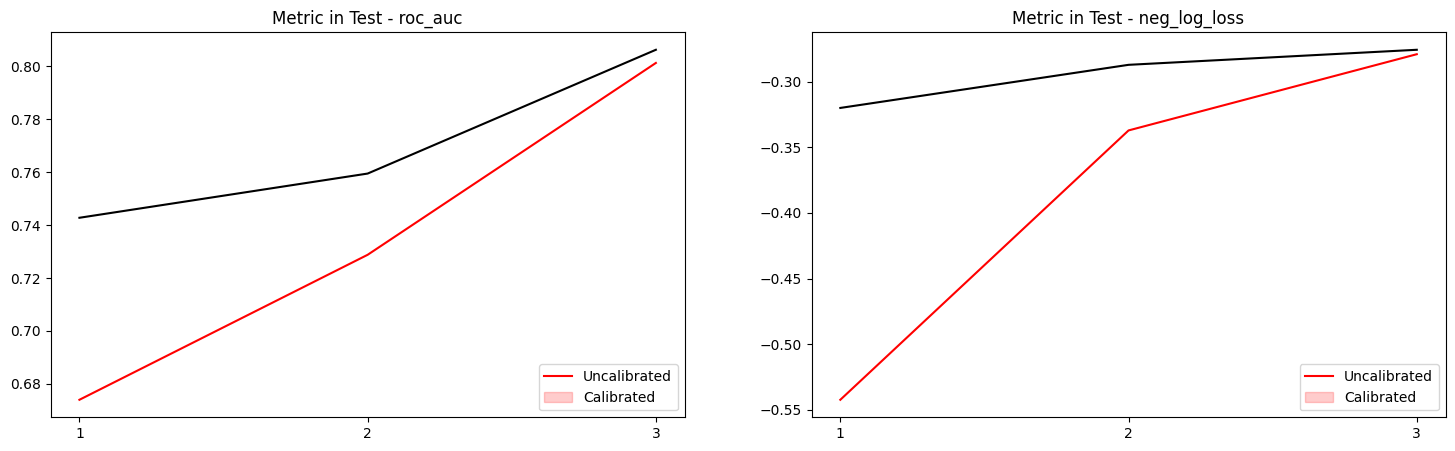

In [38]:
# Define folds number in a list
folds_n = list(simulations_df_model.ordinal_year_month.drop_duplicates().astype('str'))[: -1]

# Plots from metrics in every fold
plot_metrics_by_fold(
    folds_list=folds_n,
    metrics=score_metrics,
    cross_val_1=xgb_cv_results,
    cross_val_2=xgb_cv_results_calibrated
)

**Comments**: Da mesma forma, se observamos para cada *fold*, há uma evolução nas métricas, visto que mais dados vão sendo incorporados ao processo de **treinamento do modelo** ao adotarmos a técnica de *Rolling Basis* no processo de **Validação Cruzada**.

A performance do modelo **Calibrado** supera os do modelo **Não Calibrado**.

AUC/ROC Curve

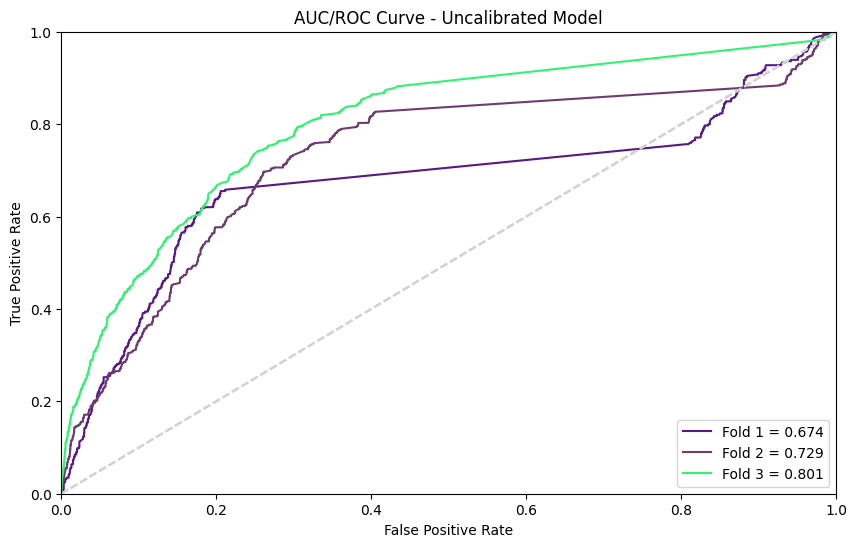

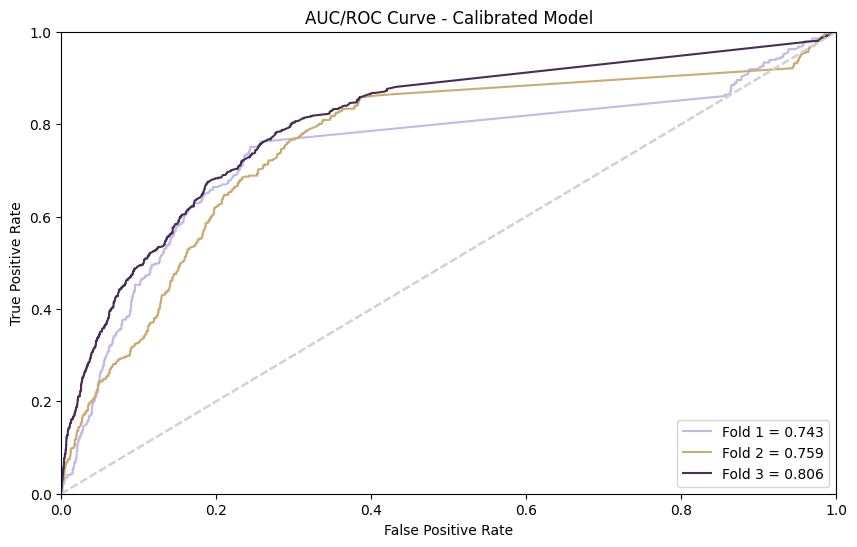

In [39]:
# Plotando curva AUC/ROC das predicoes do conjunto de validacao
plot_auc_roc(pred_list=uncalibrated_preds, title='Uncalibrated')
plot_auc_roc(pred_list=calibrated_preds, title='Calibrated')

**Comments**: Ao visualizarmos a curva *AUC/ROC*, vemos também, como a medida que novos meses vão sendo inseridos nos *folds* de treinamento durante o processo de **Validação Cruzada**, a evolução das taxas de **Verdadeiro Positivo** (TPR) e **Falso Positivo** (FPR).

Outro ponto que podemos observar é como no último *Fold* os valores de *AUC* são praticamente os mesmos, mostrando que caso o problema fosse orientado a previsão de **Classes**, o ganho da calibração seria marginal.

Calibrated Curve

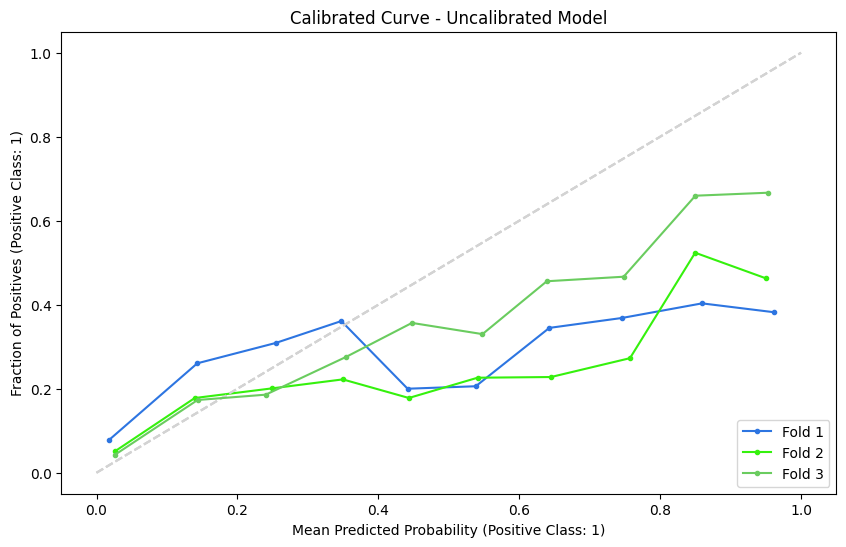

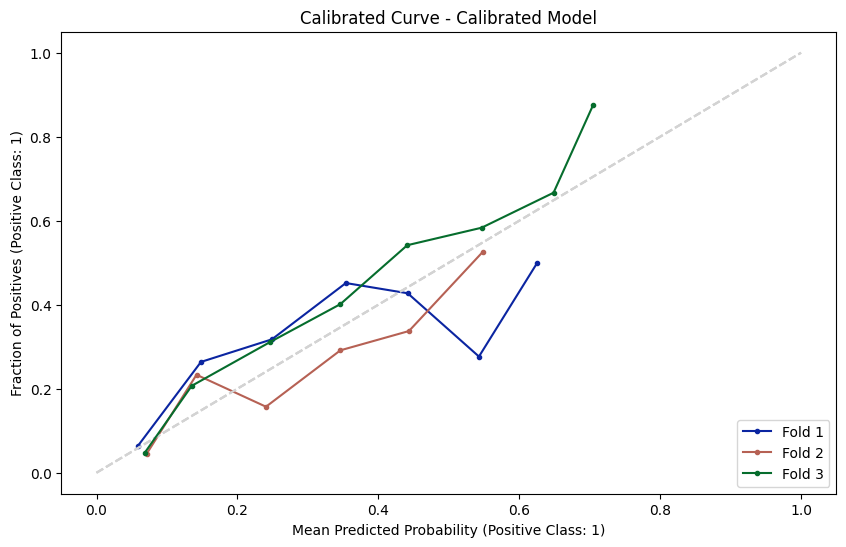

In [40]:
# Plotando curva de calibracao nos dados nao calibrados
plot_calibrated_curve(pred_list=uncalibrated_preds, title='Uncalibrated')
plot_calibrated_curve(pred_list=calibrated_preds, title='Calibrated')

**Comments**: Entretando, quando analisamos as **Curvas de Calibração** para ambos os modelos, vemos como este processo afeta as **previsões de probabilidades** dos registros.

Para que interpretemos as previsões como **probabilidades reais**, precisamos calibrar o modelo. Nesse caso, a fração de positivos deve ser **IGUAL** a média das probabilidades previstas. E veja como no modelo **Não Calibrado** essa relação se afasta da "curva perfeita".

Já no modelo **Calibrado**, essa relação tende a se equilibrar, tendo as curvas das *folds* próximas a "curva perfeita", nos mostrando um modelo cujas previsões **podem ser analisadas como probabilidades**.

##### Análise das Features

Feature Importance

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

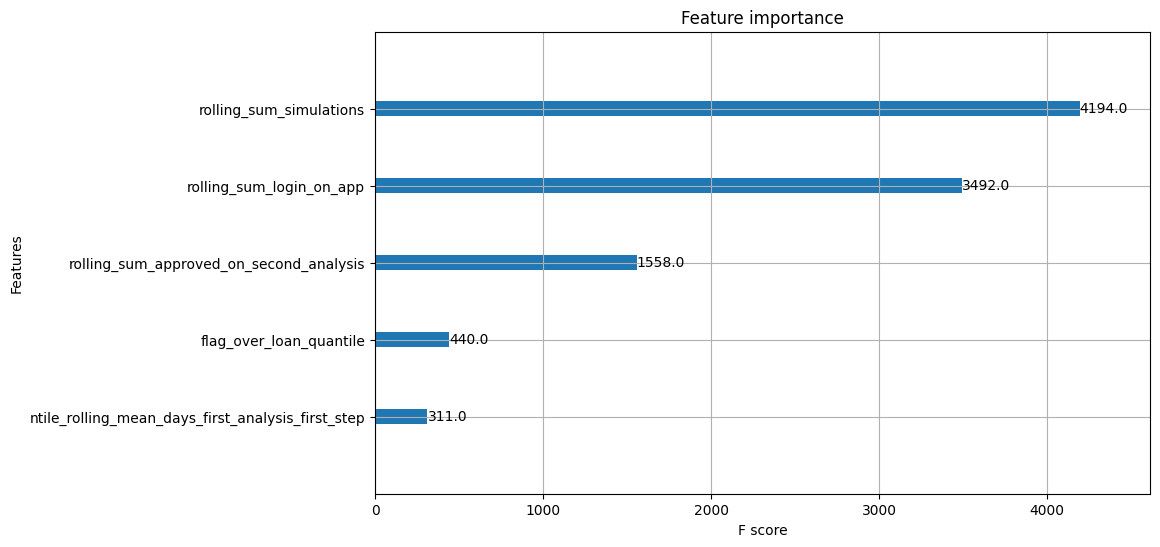

In [41]:
# Plot feature importance
xgb.plot_importance(xgb_model_calibrated.estimator)

**Comments**: Para avaliação das variáveis, a primeira métrica retirada é o de **Feature Importance**. Para o modelo calibrado, o *ranking* segue o que foi visto na etapa de **Análise Exploratória** e corresponde ao problema de negócio que se quer atacar.

Shapley

In [42]:
# Puxando valores para determinado fold da validacao cruzada
shap_values = explainer_for_fold(
    cross_val=xgb_cv_results_calibrated,
    fold_number=len(custom_folds) - 1,
    df_features=x_data,
    sample=1000
)

Exact explainer: 1001it [01:16, 12.11it/s]                          


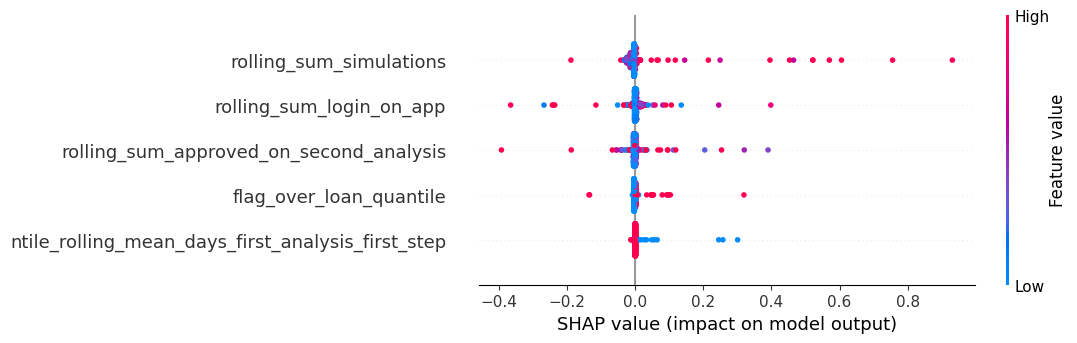

In [43]:
# Visualizacao grafica dos valores de shap
shap.plots.beeswarm(shap_values)

**Comments**: Observando o impacto das variáveis na última *fold* do modelo **Calibrado**, vemos como certas variáveis (*rolling_sum_simulations*, *ntile_rolling_mean_days_first_analysis_first_step* e *flag_over_loan_quantile*) de fato se comportam como o esperado.

Já as demais variáveis (*rolling_sum_login_on_app* e *rolling_sum_approved_on_second_analysis*) apresentam certa irracionalidade em algumas classificações de probabilidades (e.g. valores altos impactando negativamente no modelo). Nesses casos, poderíamos estudar quais as características apresentadas nesses registros e verificar a melhor forma de tratamento dos dados ou se há alguma melhoria no processo de construção do modelo em si.

### **Exportando Modelo**

In [44]:
# Nome do arquivo
filename = f"xgb_model_{datetime.now().strftime('%Y-%m-%dT%H-%M-%S')}"

# Path do modelo no projeto
model_file_name_path = os.path.join(LOCAL_PATH, 'src', 'models', 'output', filename)

# Salvando modelo final localmente
try:
    # Salvando modelo final na pasta
    joblib.dump(xgb_classifier_calibrated, f'{model_file_name_path}.pkl')
    # Convertendo para formato 'tar.gz' com comandos no terminal
    !tar -czvf {model_file_name_path}.tar.gz {model_file_name_path}.pkl
    # Removendo modelo nao zipado
    os.remove(f'{model_file_name_path}.pkl')
    # Log de sucesso na execucao
    log.info("Calibrated XGBoost model succesfully saved as 'tar.gz'!")
except ImportError:
    # Log de erro na execucao
    log.error("Something went wrong... Could not save calibrated XGBoost model as 'tar.gz'.")

tar: Removing leading drive letter from member names
a Users/daiha/OneDrive/Documentos/GitHub/app_simulation/src/models/output/xgb_model_2023-02-10T15-28-24.pkl
2023-02-10 15:28:25,201 - Logger - INFO - Calibrated XGBoost model succesfully saved as 'tar.gz'!
